In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np, os, sys
from torch import autograd
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
from sklearn.preprocessing import StandardScaler
# Select device (GPU if available)
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print(torch.cuda.is_available())
#print(torch.backends.mps.is_available())

True


In [ ]:
import astropy.constants as ac

#Constants to be used later
GMsun = ac.GM_sun.value                                  #G*(Solar Mass)
c = ac.c.value                                           #Speed of light in vacuum
dsun = GMsun/(c**2)                                      #Natural length scale
tsun = GMsun/(c**3)                                      #Natural time scale
pc = ac.pc.value                                         #One parsec
yr = (365.25)*(24)*(60)*(60)
tsun=torch.tensor(tsun)
yr=torch.tensor(yr)                 #Seconds in one year

In [ ]:
datadir="./"

In [ ]:
data_tensor = torch.load(f"{datadir}/data.pt")  # Shape: (1_000_000, 7)

# Split into inputs (first 5 columns) and outputs (last 2 columns)
X_raw = data_tensor[:, :5]  # Shape: (1_000_000, 5)
y_raw = data_tensor[:, 5:]  # Shape: (1_000_000, 2)

# Move to device safely
X_raw = X_raw.clone().detach().to(device)
y_raw = y_raw.clone().detach().to(device)

# --- Preprocessing ---

# Scale inputs (X)
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_raw.cpu().numpy())  # sklearn expects CPU numpy arrays
X = torch.tensor(X_scaled, dtype=torch.float32).to(device)

# Transform outputs y: [log10(omega), phi]
y_transformed = torch.stack([
    torch.log10(y_raw[:, 0]),  # log10(omega)
    y_raw[:, 1]                # phi
], dim=1)

# Scale outputs (y)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_transformed.cpu().numpy())
y = torch.tensor(y_scaled, dtype=torch.float32).to(device)

# --- Prepare Training Variables ---

# Inputs
t_train = X[:, 0:1]
phi0_train = X[:, 1:2]
omg0_train = X[:, 2:3]
Mc_train = X[:, 3:4]
eta_train = X[:, 4:5]

# Ground truth outputs
phi_exact_train = y[:, 1:2]
omg_exact_train = y[:, 0:1]

# --- Sanity Check ---
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"t_train sample: {t_train[0]}, phi_exact_train sample: {phi_exact_train[0]}")

X shape: torch.Size([1000000, 5]), y shape: torch.Size([1000000, 2])
t_train sample: tensor([-1.6287], device='cuda:0'), phi_exact_train sample: tensor([-0.3551], device='cuda:0')


In [ ]:

# Define PINN model
class PINN(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=2, num_hidden=4):
        super(PINN, self).__init__()
        layers = [input_size] + [hidden_size] * num_hidden + [output_size]
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Output layer
        self.net = nn.Sequential(*modules)

    def forward(self, t, phi0, omg0, Mc, eta):
        x = torch.cat([var.expand(t.shape[0], 1) for var in [t.view(-1, 1), phi0, omg0, Mc, eta]], dim=1)
        return self.net(x)
    # def forward(self, X):
    #     """
    #     Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
    #     """
    #     return self.net(X)

In [ ]:
def domg_dt(omg, Mc, eta):
    tN_omg = Mc * omg * tsun
    nu = 1.0
    PN_term = (
        (59/18)*eta**(6/5) + (13661/2016)*eta**(1/5) + (34103/18144)*eta**(-4/5)
    ) * tN_omg**(4/3) * nu**2 + \
    (4/eta**(3/5)) * nu**(3/2) * torch.pi * tN_omg + \
    (-11/4*eta**(3/5) - 43/336*eta**(-2/5)) * tN_omg**(2/3) * nu

    return (96/5) * omg**2 * tN_omg**(5/3) * (1 + PN_term)

In [ ]:
#Defining function for omega(t)
def Omega_ext(t, t0, omega0, Mc, eta, N):
    '''
    t = time
    t0 = reference epoch
    omega0 = omega(t0)
    M = total mass of the SMBHB
    eta = symmetric mass ratio
    N = 0, 1, 1.5 or 2 (0--> Newtonian order, 1--> Upto 1PN, 1.5--> Upto 1.5PN, 2--> Upto 2PN)
    '''

    #Defining some parameters/scaled variables
    #Mc = (M)*((eta)**(3/5))
    M=Mc/((eta)**(3/5))
    tm_ = tsun*M*omega0
    tau = 1 - (((256)*((Mc)**(5/3))*((tsun)**(5/3))*((omega0)**(8/3))*(t - t0))/5)

    if N==0:
        return omega0/(tau**(3/8))

    if N==1:
        return omega0*( 1 / tau**(3/8) + ((11/8 * eta + 743/672) / tau**(5/8) + (-11/8 * eta - 743/672) / tau**(11/8) ) * tm_**(2/3) )

    elif N==1.5:
        return omega0*( 1 / tau**(3/8) + ((11/8 * eta + 743/672) / tau**(5/8) + (-11/8 * eta - 743/672) / tau**(11/8) ) * tm_**(2/3) + (12/5 / tau**(11/8) * np.pi - 12/5 / tau**(3/4) * np.pi) * tm_ )

    elif N==2:
        return omega0*( 1 / tau**(3/8) + ((11/8 * eta + 743/672) / tau**(5/8) + (-11/8 * eta - 743/672) / tau**(11/8) ) * tm_**(2/3) + (12/5 / tau**(11/8) * np.pi - 12/5 / tau**(3/4) * np.pi) * tm_ + ( (371/128 * eta**2 + 56975/16128 * eta + 1855099/903168) / tau**(7/8)
        + (-617/192 * eta**2 - 5429/1344 * eta - 3058673/1354752) / tau**(11/8) + (-605/192 * eta**2 - 40865/8064 * eta - 2760245/1354752) / tau**(13/8) + (1331/384 * eta**2 + 89903/16128 * eta + 6072539/2709504) / tau**(19/8) ) * tm_**(4/3) )

In [ ]:
#Expression for Phi(t) (upto 2PN)
def Phi_ext(t, t0, phi0, omega0, Mc, eta, N):
    '''
    t = time
    t0 = reference epoch
    phi0 = phi(t0)
    omega0 = omega(t0)
    M = total mass of the SMBHB
    eta = symmetric mass ratio
    N = 0, 1, 1.5 or 2 (0--> Newtonian order, 1--> Upto 1PN, 1.5--> Upto 1.5PN, 2--> Upto 2PN)
    '''

    #Defining function for 'indefinite' Phi(omega)
    def phi(t, t0, phi0, omega0, Mc, eta, N):

        #Getting omega(t)
        omg = Omega_ext(t, t0, omega0, Mc, eta, N)

        #Defining some parameters/scaled variables
        #Mc = (M)*((eta)**(3/5))
        tN_omg = tsun*Mc*omg

        #Getting phi(t)
        if N==0:
            return - 1 / (32 * tN_omg**(5/3))

        elif N==1:
            return - 1 / (32 * tN_omg**(5/3)) + (-55/384 * eta**(3/5) - 3715/32256 / eta**(2/5)) / tN_omg

        elif N==1.5:
            return - 1 / (32 * tN_omg**(5/3)) + (-55/384 * eta**(3/5) - 3715/32256 / eta**(2/5)) / tN_omg + 5 / (16 * tN_omg**(2/3) * eta**(3/5)) * np.pi

        elif N==2:
            return - 1 / (32 * tN_omg**(5/3)) + (-55/384 * eta**(3/5) - 3715/32256 / eta**(2/5)) / tN_omg + 5 / (16 * tN_omg**(2/3) * eta**(3/5)) * np.pi + (-3085/4608 * eta**(6/5) - 27145/32256 * eta**(1/5) - 15293365/32514048 / eta**(4/5)) / tN_omg**(1/3)

    return phi(t, t0, phi0, omega0, Mc, eta, N) - phi(t0, t0, phi0, omega0, Mc, eta, N) + phi0

In [ ]:
def pinn_loss_format(model, t, phi0, omg0, Mc, eta, phi_exact, omg_exact):
    pred = model(t, phi0, omg0, Mc, eta)
    omg_pred_scaled = pred[:, 0:1]  # Scaled log10(omega)
    phi_pred_scaled = pred[:, 1:2]  # Scaled phi

    # Unscale inputs for physics computations
    t_unscaled = torch.tensor(X_scaler.inverse_transform(torch.cat([t, phi0, omg0, Mc, eta], dim=1).cpu().numpy())[:, 0:1], dtype=torch.float32).to(device)
    phi0_unscaled = torch.tensor(X_scaler.inverse_transform(torch.cat([t, phi0, omg0, Mc, eta], dim=1).cpu().numpy())[:, 1:2], dtype=torch.float32).to(device)
    omg0_unscaled = torch.tensor(X_scaler.inverse_transform(torch.cat([t, phi0, omg0, Mc, eta], dim=1).cpu().numpy())[:, 2:3], dtype=torch.float32).to(device)
    Mc_unscaled = torch.tensor(X_scaler.inverse_transform(torch.cat([t, phi0, omg0, Mc, eta], dim=1).cpu().numpy())[:, 3:4], dtype=torch.float32).to(device)
    eta_unscaled = torch.tensor(X_scaler.inverse_transform(torch.cat([t, phi0, omg0, Mc, eta], dim=1).cpu().numpy())[:, 4:5], dtype=torch.float32).to(device)

    # Compute exact solutions (using unscaled inputs)
    phi_exact_unscaled = Phi_ext(t_unscaled*yr, 0, phi0_unscaled, 10**omg0_unscaled, 10**Mc_unscaled, eta_unscaled, 2)/(2*torch.pi)
    omg_exact_unscaled = torch.log10(Omega_ext(t_unscaled*yr, 0, 10**omg0_unscaled, 10**Mc_unscaled, eta_unscaled, 2))

    # Scale the exact solutions to compare with predictions
    exact_unscaled = torch.cat([omg_exact_unscaled, phi_exact_unscaled], dim=1)
    exact_scaled = torch.tensor(y_scaler.transform(exact_unscaled.cpu().numpy()), dtype=torch.float32).to(device)
    phi_exact_scaled = exact_scaled[:, 1:2]
    omg_exact_scaled = exact_scaled[:, 0:1]

    # Data losses (in scaled space)
    loss_data_phi = torch.mean((phi_pred_scaled - phi_exact_scaled)**2)
    loss_data_omg = torch.mean((omg_pred_scaled - omg_exact_scaled)**2)

    # Initial condition losses (in scaled space)
    loss_ic_phi = torch.mean((phi_pred_scaled[0] - phi0)**2)
    loss_ic_omg = torch.mean((omg_pred_scaled[0] - omg0)**2)

    # Total loss
    loss_ic_phi_fac=1e-2
    total_loss = (
        loss_data_phi +
        loss_data_omg +
        loss_ic_phi_fac*loss_ic_phi +
        loss_ic_phi_fac*loss_ic_omg
    )

    # Return total loss and individual losses
    return total_loss, {
        "loss_data_phi": loss_data_phi,
        "loss_data_omg": loss_data_omg,
        "loss_ic_phi": loss_ic_phi_fac*loss_ic_phi,
        "loss_ic_omg": loss_ic_phi_fac*loss_ic_omg
    }

In [ ]:
model = PINN(input_size=5, hidden_size=64, output_size=2, num_hidden=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 500
losses = []

In [ ]:
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, individual_losses = pinn_loss_format(
        model, t_train, phi0_train, omg0_train, Mc_train, eta_train,
        phi_exact_train, omg_exact_train
    )
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6e}")
        print(f"  Data Phi Loss = {individual_losses['loss_data_phi'].item():.6e}")
        print(f"  Data Omega Loss = {individual_losses['loss_data_omg'].item():.6e}")
        print(f"  IC Phi Loss = {individual_losses['loss_ic_phi'].item():.6e}")
        print(f"  IC Omega Loss = {individual_losses['loss_ic_omg'].item():.6e}")

Epoch 0: Total Loss = 2.079148e+00
  Data Phi Loss = 1.045901e+00
  Data Omega Loss = 1.013228e+00
  IC Phi Loss = 1.000066e-02
  IC Omega Loss = 1.001872e-02
Epoch 100: Total Loss = 8.318006e-02
  Data Phi Loss = 4.347140e-02
  Data Omega Loss = 7.977785e-03
  IC Phi Loss = 1.016319e-02
  IC Omega Loss = 2.156769e-02
Epoch 200: Total Loss = 6.248686e-02
  Data Phi Loss = 2.899373e-02
  Data Omega Loss = 3.790910e-03
  IC Phi Loss = 1.045407e-02
  IC Omega Loss = 1.924815e-02
Epoch 300: Total Loss = 5.520381e-02
  Data Phi Loss = 2.555279e-02
  Data Omega Loss = 3.334958e-03
  IC Phi Loss = 1.048383e-02
  IC Omega Loss = 1.583224e-02
Epoch 400: Total Loss = 5.093345e-02
  Data Phi Loss = 2.438482e-02
  Data Omega Loss = 3.048970e-03
  IC Phi Loss = 1.031828e-02
  IC Omega Loss = 1.318138e-02


Predicted (unscaled) [log10(omega), phi]: tensor([[-7.4522,  3.9011],
        [-9.2354, -0.0146],
        [-7.4256,  5.5006],
        [-9.6760,  0.7064]], device='cuda:0')
True (unscaled) [log10(omega), phi]: tensor([[-7.5040,  3.6748],
        [-9.2387,  0.0511],
        [-7.4234,  5.5994],
        [-9.6454,  0.7495]], device='cuda:0')


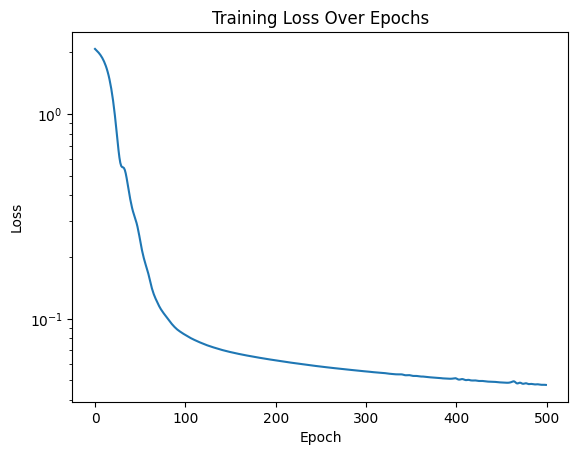

In [ ]:
# Cell 9: Evaluation
#torch.tensor(y_scaler.inverse_transform(y_pred_scaled.cpu().numpy()), dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    # Unpack X into its components (already scaled)
    t = X[:, 0:1]
    phi0 = X[:, 1:2]
    omg0 = X[:, 2:3]
    Mc = X[:, 3:4]
    eta = X[:, 4:5]

    # Get predictions (scaled)
    y_pred_scaled = model(t, phi0, omg0, Mc, eta)  # Shape: (1000000, 2)

    # Unscale predictions
    y_pred_unscaled = torch.tensor(y_scaler.inverse_transform(y_pred_scaled.cpu().numpy()), dtype=torch.float32).to(device)

# Print predictions for a sample (e.g., index 1)
print("Predicted (unscaled) [log10(omega), phi]:", y_pred_unscaled[1:5])
print("True (unscaled) [log10(omega), phi]:", y_transformed[1:5])

# Optional: Plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.yscale("log")
plt.show()

In [ ]:
# store data points
outdir="PINN_ODE_CIRC_t2"
os.makedirs(outdir, exist_ok=True)

In [ ]:
import joblib

# Save scalers
joblib.dump(X_scaler, f"{outdir}/X_scaler.pkl")
joblib.dump(y_scaler, f"{outdir}/y_scaler.pkl")

['PINN_ODE_CIRC_t2/y_scaler.pkl']

In [ ]:
torch.save(model.state_dict(), f"{outdir}/model_weights.pth")
torch.save(model, f"{outdir}/model_full.pth")

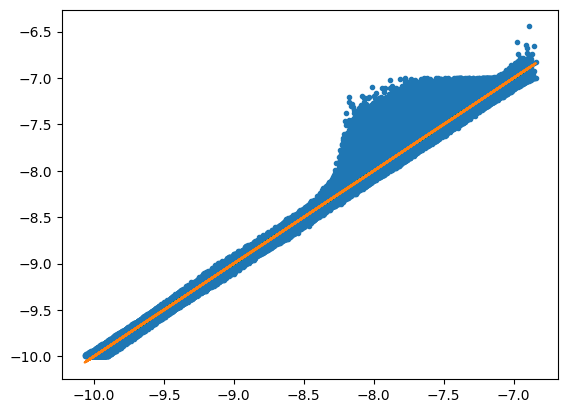

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
plt.plot(y_pred_unscaled[:,0].cpu().numpy(),y_transformed[:, 0].cpu().numpy(),marker='.',ls='')
plt.plot(y_pred_unscaled[:,0].cpu().numpy(),y_pred_unscaled[:,0].cpu().numpy())

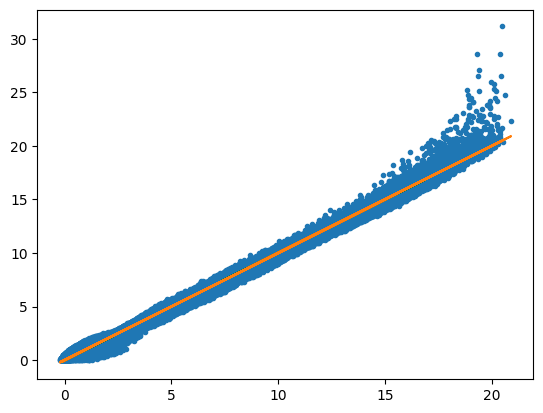

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
plt.plot(y_pred_unscaled[:,1].cpu().numpy(),y_transformed[:, 1].cpu().numpy(),marker='.',ls='')
plt.plot(y_pred_unscaled[:,1].cpu().numpy(),y_pred_unscaled[:,1].cpu().numpy())